In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

# 1. Lecture des taux de la BCE et plot

In [211]:
data_rates = pd.read_csv(

    'data/ECB Data Portal daily_20241213172734.csv',
    index_col=0,
    header=0,
    names=[
        'Date',
        'Time_Period',
        'Deposit_Change',
        'Deposit_Level',
        'Lending_Change',
        'Lending_Level',
        'Refinancing_Change',
        'Fixed_Rate_Level',
        'Variable_Rate_Level',
        'Deposit_Level_Alt',
        'Fixed_Rate_Level_Alt',
        'Min_Bid_Rate_Level'
    ],
    
    parse_dates=True,

    ).drop(columns='Time_Period')


<Axes: xlabel='Date'>

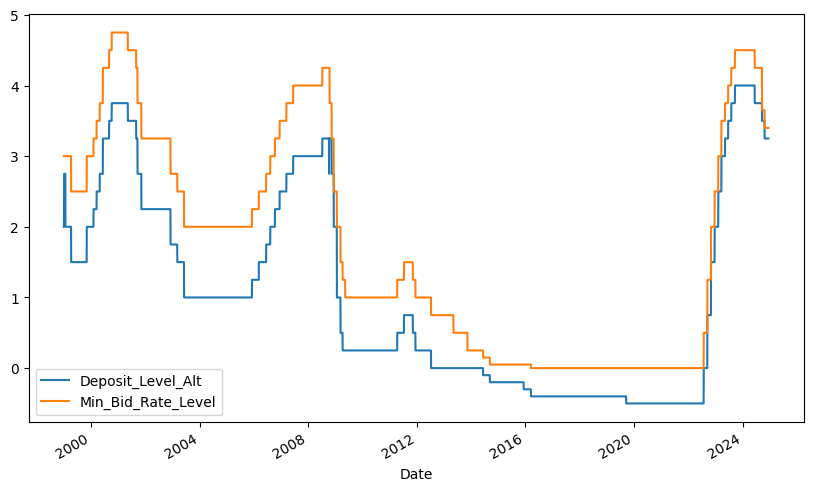

In [212]:
data_rates[['Deposit_Level_Alt', 'Min_Bid_Rate_Level']].plot(figsize=(10,6))

### Affichons les dates ou les changements ont été positifs/négatifs

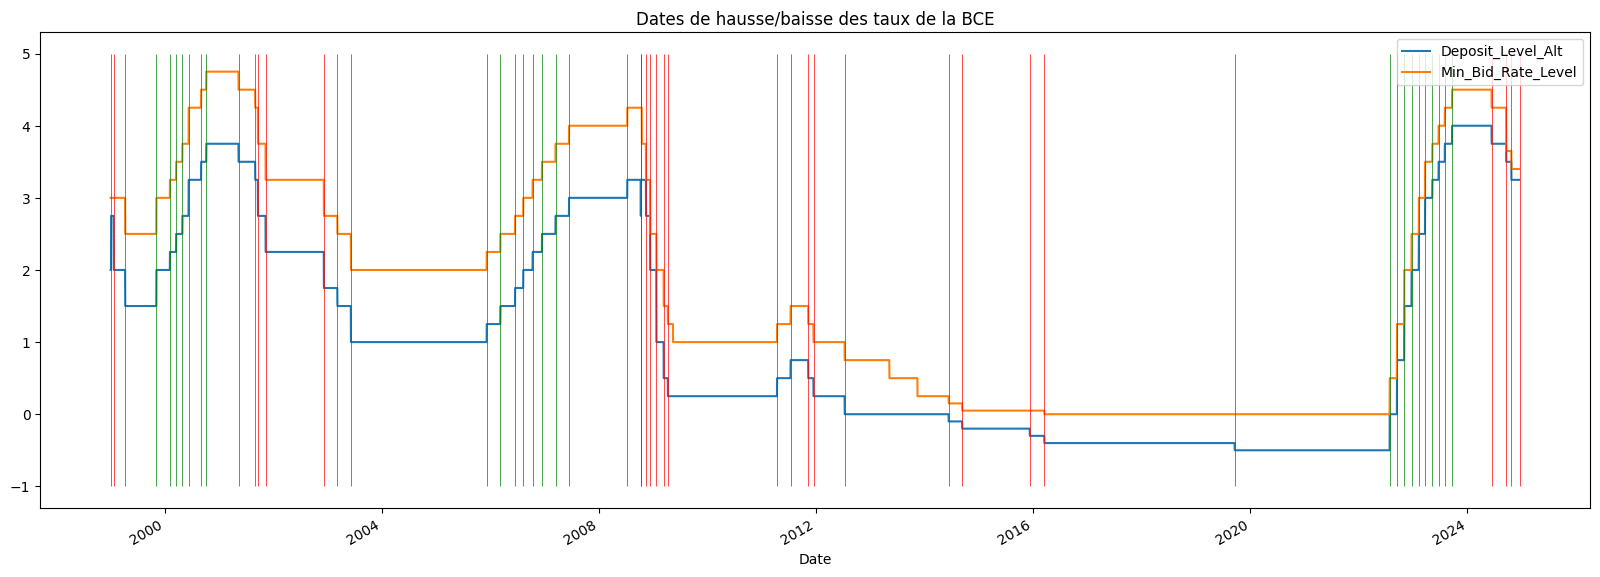

In [213]:
changes_pos = data_rates.query('Deposit_Change > 0')
changes_neg = data_rates.query('Deposit_Change < 0')

fig, ax = plt.subplots(figsize=(20,7))

data_rates[['Deposit_Level_Alt', 'Min_Bid_Rate_Level']].plot(ax=ax, title='Dates de hausse/baisse des taux de la BCE')

ax.vlines(changes_pos.index, ymin=-1, ymax=5, linewidth=0.5, color='g')
ax.vlines(changes_neg.index, ymin=-1, ymax=5, linewidth=0.5, color='r')


# 2. Connaître les taux permet-il de générer de l'Alpha?

## 2.1 Analyse Empirique

### L'intuition basique sur laquelle on va se baser:
- La hausse des taux entraîne une baisse des actions
- La baisse des taux entraîne une hausse du prix des actions

### Indice européen utilisé pour vérifier cela empiriquement:
- Euro Stoxx 50 
- MSCI Europe Small Cap Index

### Comment nous le testerons?
Avec une simple stratégie long-short

In [214]:
euro_stoxx_50 = yf.download('^STOXX50E',
                            start = data_rates.index.min(),
                            end = data_rates.index.max()
                            )['Close']


msci_small = yf.download('IEUS',
                            start = data_rates.index.min(),
                            end = data_rates.index.max()
                            )['Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### L'Euro Stoxx 50 et le MSCI Europe Small Cap commencent en 2007, nous allons restreindre notre étude de 2007 à 2024

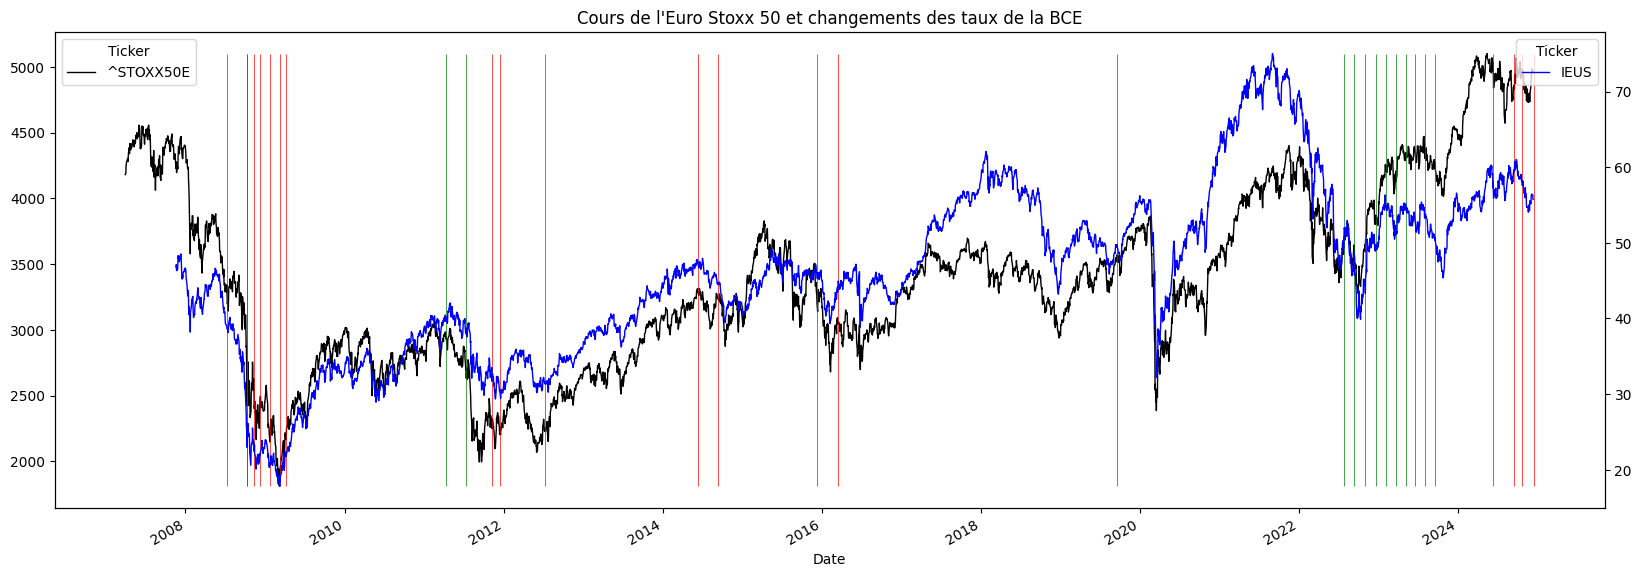

In [222]:
fig, ax = plt.subplots(figsize=(20,7))
ax2 = ax.twinx()

max_es50 = euro_stoxx_50.max()
min_es50 = euro_stoxx_50.min()

min_date_es50 = euro_stoxx_50.index.min()
min_date_msciSC = msci_small.index.min()
min_date = max(min_date_es50, min_date_msciSC)

euro_stoxx_50.plot(ax = ax, linewidth=1, color='black', title="Cours de l'Euro Stoxx 50 et changements des taux de la BCE")
msci_small.plot(ax = ax2, linewidth=1, color='blue')

ax.vlines(changes_pos.query('index >= @min_date').index, ymin=min_es50, ymax=max_es50, linewidth=0.5, color='g')
ax.vlines(changes_neg.query('index >= @min_date').index, ymin=min_es50, ymax=max_es50, linewidth=0.5, color='r')

### Visuellement il semble être possible de générer de l'alpha si on connaît les cours en avance, puisque notre intuition semble correcte par rapport à la baisse/hausse des prix des actions européennes

## 2.2 BackTesting d'une stratégie simple (Long-Short) uniquement sur les jours de changements des taux

In [224]:
euro_stoxx_50['rt_es50'] = euro_stoxx_50['^STOXX50E'].pct_change()*100
msci_small['rt_msci_small'] = msci_small['IEUS'].pct_change()*100

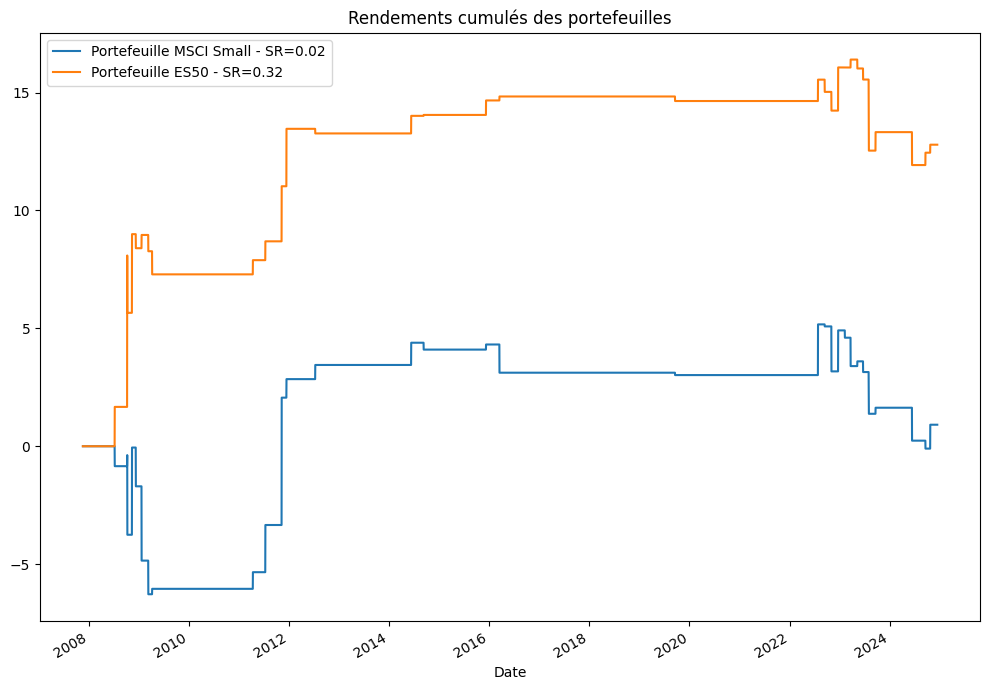

In [292]:
merge_msciSC_es50 = euro_stoxx_50.merge(msci_small, left_index=True, right_index=True)


merge_msciSC_es50 = merge_msciSC_es50.assign(
    signal = np.where(merge_msciSC_es50.index.isin(changes_pos.query('index >= @min_date').index), 1, 
    np.where(merge_msciSC_es50.index.isin(changes_neg.query('index >= @min_date').index), -1, 0))
)
                    

merge_msciSC_es50['pf_msciSC'] = merge_msciSC_es50['rt_msci_small']*merge_msciSC_es50.signal
merge_msciSC_es50['pf_es50'] = merge_msciSC_es50['rt_es50']*merge_msciSC_es50.signal

sharpe_pf_msciSC = np.sqrt(252)* (merge_msciSC_es50['pf_msciSC'].mean() / (merge_msciSC_es50['pf_msciSC'].std()))
sharpe_pf_es50 = np.sqrt(252)* (merge_msciSC_es50['pf_es50'].mean() / (merge_msciSC_es50['pf_es50'].std()))


fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Rendements cumulés des portefeuilles')

merge_msciSC_es50['pf_msciSC'].cumsum().plot(ax=ax, label=f'Portefeuille MSCI Small - SR={sharpe_pf_msciSC.round(2)}')
merge_msciSC_es50['pf_es50'].cumsum().plot(ax=ax, label=f'Portefeuille ES50 - SR={sharpe_pf_es50.round(2)}')

ax.legend()
fig.tight_layout()


